In [1]:
from info import * 
from preprocess import *
from utils import *

import sys
import cProfile
from functools import wraps, lru_cache
from warnings import simplefilter

# TODO: automatic unit testing
# TODO speedup w/ less memory: caching (@lru_cache(maxsize=12)), parallelize, decorators, generators, better data typing, figure out -> from numba import njit
# TODO: data type automatically? 
# TODO: need an ANGLE consistency variable...?

/Users/matthew/opt/anaconda3/envs/social_navigation_task/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/matthew/opt/anaconda3/envs/social_navigation_task/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


# ComputeBehavior

In [7]:
from numpy import asarray, linalg
import numpy.lib.recfunctions as rfn
from scipy.spatial import ConvexHull, Delaunay, procrustes
from shapely.geometry import Polygon, MultiPoint, mapping
import alphashape
import pycircstat

data = pd.read_excel(example_org_file)
compute = ComputeBehavior2(data)
compute.run()
compute.out.columns # this will be the standard

Index(['index', 'responded', 'affil_decision', 'power_decision', 'affil_coord',
       'power_coord', 'affil_coord_mean', 'power_coord_mean', 'affil_centroid',
       'power_centroid', 'neu_dist', 'neu_dist_mean', 'neu_2d_angle',
       'neu_2d_angle_mean', 'neu_3d_angle', 'neu_3d_angle_mean', 'pov_dist',
       'pov_dist_mean', 'pov_2d_angle', 'pov_2d_angle_mean', 'pov_3d_angle',
       'pov_3d_angle_mean', 'affil_consistency', 'power_consistency',
       'consistency', 'affil_coord_overallmean', 'power_coord_overallmean',
       'affil_centroid_overallmean', 'power_centroid_overallmean',
       'neu_dist_overallmean', 'neu_2d_angle_overallmean',
       'neu_3d_angle_overallmean', 'pov_dist_overallmean',
       'pov_2d_angle_overallmean', 'pov_3d_angle_overallmean',
       'affil_consistency_overallmean', 'power_consistency_overallmean',
       'consistency_overallmean', 'perimeter', 'area', 'pov_perimeter',
       'pov_area', 'Q1_overlap', 'Q2_overlap', 'Q3_overlap', 'Q4_overlap'],
 

# Plotting the area

In [3]:
from shapely.geometry import MultiPoint, mapping
from descartes import PolygonPatch
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

sys.path.insert(0, f"{os.path.expanduser('~')}/Dropbox/Projects/toolbox/toolbox")
import circ_stats

def angle_to_vec_unit(angle, dtype='float32'):
    '''
        convert an angle in radians to unit vector
        assumes counterclockwise angle
        unit vector is agnostic to distance
    '''
    angle = np.array(angle, dtype=dtype) # in case its a list, etc
    return np.hstack([np.cos(angle), np.sin(angle)]).astype(dtype).T

def polar_to_vec_comps(angle, dist, dtype='float32'):
    '''
        convert an angle (radians) and distance to the x & y components of the vector
        returns an array of shape: [n_obs, 2 (x/y)]
    '''
    angle = np.array(angle, dtype=dtype) 
    dist  = np.array(dist, dtype=dtype)
    return np.hstack([dist*np.cos(angle), dist*np.sin(angle)]).astype(dtype)

# having the problem of the origin coordinate not always being included in the concave solution...
def sort_vertices_counterclockwise(vertices):
    angles = [np.arctan2(*v) for v in vertices]
    A = np.hstack([np.array(angles)[:,np.newaxis], vertices])
    sorted_by_angle = A[A[:, 0].argsort()]
    return sorted_by_angle[:, 1:] # return only 

def get_cmap_colors(cmap):
    # usage: get_cmap_colors(cm.get_cmap('plasma', 101))
    return [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]


In [4]:
data = pd.read_excel(example_org_file)
coords = compute.out['current_constant_actual'][['affil_coord','power_coord']].values

/Users/matthew/opt/anaconda3/envs/social_navigation_task/lib/python3.10/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


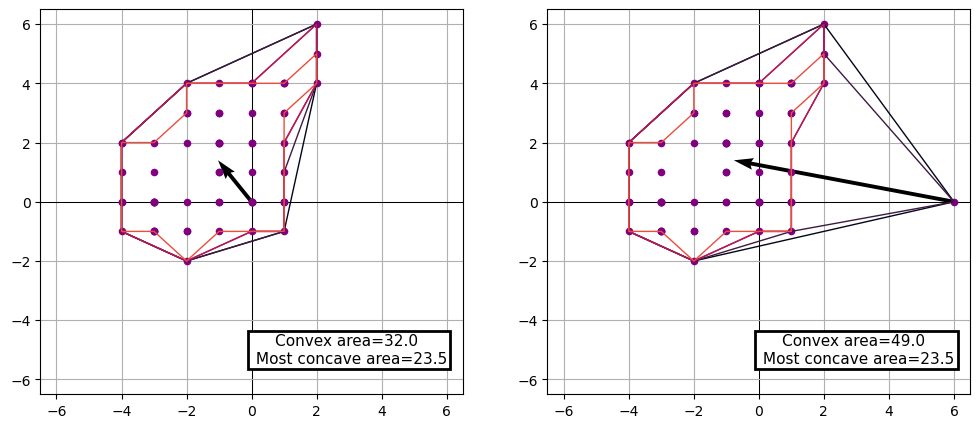

In [5]:
# TODO: error checking

ref_frames = {'neu': {'origin': np.array([[0,0]]), 'ref_vec': np.array([[6,0]]), 'angle_drn': False},
              'pov': {'origin': np.array([[6,0]]), 'ref_vec': np.array([[6,6]]), 'angle_drn': None}} 

plt.rc('axes', axisbelow=True)
figsize = (12,5)
fig, axs = plt.subplots(1, 2, figsize=figsize)
color = 'purple'
colors = get_cmap_colors(sns.color_palette("rocket", as_cmap=True))
for r, (ori, ref_frame) in enumerate(ref_frames.items()):  
    
    # grid lines 
    axs[r].axis([-6.5, 6.5, -6.5, 6.5])
    axs[r].grid()
    b = axs[r].get_xgridlines()[4] # outline axis
    b.set_color('black')
    b.set_linewidth(.75)
    b = axs[r].get_ygridlines()[4]
    b.set_color('black')
    b.set_linewidth(.75)    
    axs[r].set_xlabel('')
    axs[r].set_ylabel('')

    # (1) plotting average vector
    mean_xy = np.mean(coords - ref_frame['origin'], axis=0)
    axs[r].quiver(ref_frame['origin'][0][0], ref_frame['origin'][0][1], 
                  mean_xy[0], mean_xy[1], 
                  units='xy', scale=1, color='black', 
                  width=.025 * figsize[1]) 

    # (2) plotting shape 
    coords_ = np.vstack([ref_frame['origin'], coords]) # add origin in
    axs[r].scatter(*zip(*coords_), s=20, color='purple')

    areas = []
    for a, alpha in enumerate(np.arange(0, 1, .2)):
        hull = alphashape.alphashape(coords_, alpha) # convex hull when alpha = 0, concave when not
        hull_vertices = np.array(mapping(hull)['coordinates'][0]) # hull.exterior.coords
        # hull.exterior.coords
        areas.append(hull.area)
        axs[r].add_patch(PolygonPatch(hull, color=colors[a*40], fill=None)) 

    # add area text to plot
    axs[r].text(3, -5, 
                f"""Convex area={areas[0]} \n Most concave area={areas[-1]}""", 
                ha="center", va="center", size=11,
                bbox=dict(boxstyle="square, pad=0.2", fc="white", ec="black", lw=2))

plt.show()


### Test & profile

In [12]:
cProfile.run("compute.run()") # profile time

         200172 function calls (195048 primitive calls) in 2.667 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        6    0.000    0.000    0.000    0.000 223038951.py:127(get_decisions)
        6    0.000    0.000    0.001    0.000 223038951.py:156(weight_decisions)
        6    0.000    0.000    0.001    0.000 223038951.py:177(get_coords)
       12    0.003    0.000    0.006    0.000 223038951.py:202(make_3d)
       24    0.002    0.000    1.832    0.076 223038951.py:225(calc_angle)
       12    0.001    0.000    0.017    0.001 223038951.py:262(calc_distance)
       12    0.001    0.000    0.016    0.001 223038951.py:264(<listcomp>)
        7    0.000    0.000    0.000    0.000 223038951.py:271(cumulative)
        7    0.002    0.000    0.576    0.082 223038951.py:274(wrapper)
        7    0.007    0.001    0.571    0.082 223038951.py:276(<listcomp>)
       63    0.156    0.002    0.520    0.008 223038951.py:338(calc_

In [73]:
user = os.path.expanduser('~')
sys.path.insert(0, f'{user}/Dropbox/Projects/social_navigation_analysis/tests')
from test_utils import *

import unittest
class TestBehavior(unittest.TestCase):
    ''' 
        inherits unittest.TestCase 
        any method with test_ in prefix will be considered a test    
    '''
    # TODO: also test at the ned of the funciton, running real data through - that notjing in the sorting etc fucks shit up...
    # compute = ComputeBehavior2(file=None)
    iters    = 5
    n_trials = 12
    almost_tol = 5 # bc using not super precise floats

    #------------------
    # input/output
    #------------------
    
    def test_check_input(self):
        exp_shapes = [(2,2), (3,2)]
        to_check = np.array([(3,2),[3,2]])
        bool = ComputeBehavior2.check_input(to_check, exp_shapes)
        self.assertEqual(True, bool, 'Shape checker is off')

    # def test_run_output_shape(self):
    #     compute = ComputeBehavior2(file=random_behavior_data())
    #     compute.run()
    #     self.assertEqual(compute.dfs['current_constant_actual']['character_coords'].shape[0], 63, 'There are not 63 rows in the outputted dataframe')
    #     # self.assertEqual(self.compute.behavior.shape[1], 15*num_models, f'There are not {} columns in the outputted dataframe')

    #------------------------------------
    # decision weighting etc
    #------------------------------------
    
    def test_get_decisions_current(self):
        decisions_raw = random_behavior_data()['decision'].values.astype(int)
        decisions = ComputeBehavior2.get_decisions(decisions_raw, which='current')
        self.assertListEqual(decisions_raw.tolist(), decisions.tolist(), 'Current decisions off')

    def test_get_previous_decisions(self):
        decisions      = fake_decisions_2d(n_trials=self.n_trials)
        prev_decisions = ComputeBehavior2.get_decisions(decisions, which='previous', shift_by=1)
        self.assertEqual(prev_decisions.shape, (self.n_trials,2))
        self.assertListEqual(prev_decisions[0,:].tolist(), [0,0], 'Previous decisions in row 0 do not equal [0,0]')
        self.assertListEqual(prev_decisions[1:].tolist(), decisions[0:-1].tolist(), 'Previous decisions in row 1:end do not equal decisions row 0:end-1')

    def test_weight_decisions_constant(self):
        decisions = random_behavior_data()['decision'].values.astype(float)
        decisions_weighted = ComputeBehavior2.weight_decisions(decisions, weights='constant')[0]
        self.assertListEqual(decisions.tolist(), decisions_weighted.tolist(), 'Constant weighted decisions are off')

    # def test_weight_decisions_exponential(self): 

    # def test_weight_decisions_linear(self): 

    def test_get_coords_actual(self):
        decisions = fake_decisions_2d(n_trials=self.n_trials)
        coords2   = ComputeBehavior2.get_coords(decisions, which='actual')
        self.assertEqual(coords2.shape, (self.n_trials, 2))
        self.assertListEqual(np.cumsum(decisions, axis=0).tolist(), coords2.tolist(), 'Coordinates do not equal the cumulative sum of the decisions')
        self.assertEqual(np.sum(decisions[:, 0]), coords2[-1, 0], 'The last affil coordinate is not what it should be')
        self.assertEqual(np.sum(decisions[:, 1]), coords2[-1, 1], 'The last power coordinate is not what it should be')

    def test_get_coords_counterfactual(self):
        decisions  = fake_decisions_2d(n_trials=self.n_trials)
        coords     = np.cumsum(decisions, axis=0)
        cf_coords  = coords-(2*decisions)
        cf_coords2 = ComputeBehavior2.get_coords(decisions, which='counterfactual')
        self.assertEqual(cf_coords2.shape, (self.n_trials, 2))
        self.assertListEqual(cf_coords.tolist(), cf_coords2.tolist(), 'Countefactual decisions are wrongly computed')

    def test_get_coords_demeaning(self):
        coords2 = ComputeBehavior2.get_coords(fake_decisions_2d(n_trials=self.n_trials), which='actual', demean=True)
        self.assertAlmostEqual(float(np.mean(coords2, axis=0)[0]), 0, self.almost_tol, 'The demeaning isnt accurate within 5 decimal places')
        coords2 = ComputeBehavior2.get_coords(fake_decisions_2d(n_trials=self.n_trials), which='counterfactual', demean=True)
        self.assertAlmostEqual(float(np.mean(coords2, axis=0)[0]), 0, self.almost_tol, 'The demeaning isnt accurate within 5 decimal places for counterfactual')
    
    #------------------------------------
    #------------------------------------

    def test_cumulative_mean(self):

        decisions = fake_decisions_2d(n_trials=self.n_trials)
        resp_mask = decisions != 0
        cum_sum   = np.cumsum(decisions, axis=0)
        cum_count = np.cumsum(resp_mask, axis=0)

        # with resp_mask arg
        cum_mean  = ComputeBehavior2.calc_cumulative_mean(decisions, resp_mask)
        self.assertAlmostEqual(cum_mean[-1,0], cum_sum[-1,0] / cum_count[-1,0], self.almost_tol, 'Cumulative mean for 1st dimension (ie, affiliation) is off')
        self.assertAlmostEqual(cum_mean[-1,1], cum_sum[-1,1] / cum_count[-1,1], self.almost_tol, 'Cumulative mean for 2nd dimension (ie, power) is off')

        # without resp_mask arg
        cum_mean  = ComputeBehavior2.calc_cumulative_mean(decisions, resp_mask=None)
        self.assertAlmostEqual(cum_mean[-1,0], cum_sum[-1,0] / cum_count[-1,0], self.almost_tol, 'Cumulative mean for 1st dimension (ie, affiliation) is off')
        self.assertAlmostEqual(cum_mean[-1,1], cum_sum[-1,1] / cum_count[-1,1], self.almost_tol, 'Cumulative mean for 2nd dimension (ie, power) is off')

    def test_quadrant_overlap_sum1_and_correct_quad(self):

        q1_coords = np.array([[4,4], [-1,4], [-1,-1], [4,-1]])
        q2_coords = q1_coords - np.repeat([[3,0]], 4, axis=0) # x-3
        q3_coords = q2_coords - np.repeat([[0,3]], 4, axis=0) # y-3
        q4_coords = q3_coords + np.repeat([[3,0]], 4, axis=0) # x+3

        for q, qC in enumerate([q1_coords, q2_coords, q3_coords, q4_coords]):

            overlap = ComputeBehavior2.calc_quadrant_overlap(qC)
            summed = np.sum(overlap)
            self.assertAlmostEqual(summed, 1, self.almost_tol, f'The overlap sum {summed}!=1')
            
            max_quad = np.where(overlap == np.max(overlap))[0][0]
            self.assertAlmostEqual(max_quad, q, self.almost_tol, f'The quarant with the max value {max_quad}!={q}')

    def test_centroids(self):
        # not sure what else to tes there
        decisions = fake_decisions_2d(n_trials=self.n_trials)
        coords    = np.cumsum(decisions, 0)
        centroids = ComputeBehavior2.calc_centroid(coords)

        self.assertGreater(np.max(coords, 0)[0], centroids[0][0])
        self.assertGreater(np.max(coords, 0)[1], centroids[0][1])

unittest.main(argv=['first-arg-is-ignored'], exit=False) # arguments are to run in nb
# %run -i '../tests/test_behavior.py'

..........
----------------------------------------------------------------------
Ran 10 tests in 0.048s

OK


In [72]:
ComputeBehavior2.calc_centroid(coords)[0][0]

-0.90625

## DEV: speed up angle calculations

In [4]:
# TODO: speed this up!

def _coincident_vectors(u, v):
    ''' Checks if vectors (u & v) are the same or scalar multiples of each other'''
    return np.dot(u, v) * np.dot(u, v) == np.dot(u, u) * np.dot(v, v)


def angle_between_vectors(u, v, direction=None, verbose=False):
    '''
        Compute elementwise angle between sets of vectors u & v
            
        uses np.arctan2(y,x) which computes counterclockwise angle [-π, π] between origin (0,0) and x, y
        clockwise v. counterclockwise: https://itecnote.com/tecnote/python-calculate-angle-clockwise-between-two-points/  
        included: ADD LINK

        TODO: make pairwise..?

        Arguments
        ---------
        u : array-like
            vector
        v : array-like
            another vector
        direction : None, True or False (optional, default=None)
            None == Included
            True == Clockwise 360
            False == Counterclockwise 360 
        verbose : bool (optional, default=False)
             
        Returns
        -------
        float 
            angle in radians 

        [By Matthew Schafer; github: @matty-gee; 2020ish]
    '''

    #     if U.shape != V.shape:
    #         if verbose: print(f'Different shape vectors: U={U.shape}, V={V.shape}. Assuming smaller is reference.')
    #         if len(U) < len(V): U = np.repeat(np.expand_dims(U, 0), len(V), axis=0)
    #         else:               V = np.repeat(np.expand_dims(V, 0), len(U), axis=0)
    #     rads = []
    #     for u, v in zip(U, V):        
    # 
    #     
    # if one of vectors is at origin, the angle is undefined but could be considered as orthogonal (90 degrees)
    if ((u==0).all()) or ((v==0).all()): 
        if verbose: print(u, v, 'at least 1 vector at origin; treating as orthogonal')
        rad = np.pi/2

    # if same vectors (or scalar multiples of each other) being compared, no angle between (0 degrees)
    # -- b/c 0-360 degrees, direction matters: make sure the signs are the same too
    elif (_coincident_vectors(u, v)) & all(np.sign(u) == np.sign(v)):
        if verbose: print(u, v, 'same vectors, no angle in between')
        rad = 0 # 0 degrees == 360 degrees == 2*pi radians 

    else:

        if direction is None: 

            # "included" angle from [0,180], [0, π] 
            rad = np.arccos(np.dot(u, v) / (linalg.norm(u) * linalg.norm(v)))
            # equivalent: np.arctan2(l2_norm(np.cross(u, v)), np.dot(u, v))

        elif direction is True: 

            # clockwise angle from [0,360], [0, 2π]
            # -- compute vector angles from origin & take difference, then convert to 360 degrees
            rad = (np.arctan2(*v[::-1]) - np.arctan2(*u[::-1])) % (2 * np.pi)  
        
        elif direction is False:

            # counterclockwise angle from [0,360], [0, 2π]
            # -- compute vector angles from origin & take difference, then convert to 360 degrees
            rad = (np.arctan2(*u[::-1]) - np.arctan2(*v[::-1])) % (2 * np.pi)
            
    return rad


def calculate_angle(U, V=None, direction=None, force_pairwise=True, verbose=False):
    '''
        Calculate angles between n-dim vectors 
        If V == None, calculate U pairwise
        Else, calculate elementwise
        
        TODO: more explanation; find more elegant ways to do this; also adapt other pairwise like functions to have structure

        Arguments
        ---------
        U : array-like
            shape (n_vectors, n_dims)
        V : array-like
            shape (n_vectors, n_dims)
        direction : optional (default=None)
            None : included 180
            False : counterclockwise 360 (wont give a symmetrical matrix)
            True : clockwise 360
            
        Returns
        -------
        numeric 
            pairwise angles in radians

        [By Matthew Schafer; github: @matty-gee; 2020ish]
    '''
    
    # # testing (10-12-22)
    # U = np.random.randint(100, size=(4,2))
    # for V in [None, np.random.randint(100, size=U.shape), 
    # np.random.randint(100, size=(1, U.shape[1])), np.random.randint(100, size=(7, U.shape[1]))]:

    messages = []

    # check/fix shapes
    if U.ndim == 1: 
        U = np.expand_dims(U, 0)
        messages.append('Added a dimension to U')
        
    if V is not None:
        if V.ndim == 1: 
            V = np.expand_dims(V, 0)
            messages.append('Added a dimension to V')

            
    # determine output shape 
    # - 1 set of vectors: pw, square, symm
    if V is None: 
        default = 'pairwise'
        V = U 
        
    # - 2 vectors of same shape
    # -- pw, square, non-symm
    # -- ew, vector
    elif U.shape == V.shape: 
        default = 'elementwise' 

    # - 2 vectors, 1 w/ length==1 & is reference
    # -- pw, vector shape (1,u)
    elif (U.shape[0] > 1) & (V.shape[0] == 1): 
        V = np.repeat(V, len(U), 0) 
        default = 'reference'  
    
    # -- pw, vector shape (v,1)
    elif (U.shape[0] == 1) & (V.shape[0] > 1): 
        U = np.repeat(U, len(V), 0) 
        default = 'reference' 
        
    # - 2 vectors, different lengths
    # -- pw, rectangle 
    else: 
        default = 'pairwise' 
        
    messages.append(f'Calculated {default}')
    
    
    # calculate angles
    # if pairwise dont have to compute every angle.. but gotta be careful abouyt symmetric and not 
    radians = np.zeros((U.shape[0], V.shape[0]))
    for i in range(U.shape[0]):
        for j in range(V.shape[0]):
            radians[i, j] = angle_between_vectors(U[i,:], V[j,:], direction=direction)

            
    # output
    if default == 'pairwise': cols = 'U'
    else:                     cols = 'V'
    radians = pd.DataFrame(radians, index=[f'U{i+1:02d}' for i in range(len(U))], columns=[f'{cols}{i+1:02d}' for i in range(len(V))])

    if not force_pairwise:
        if default == 'reference':
            radians = radians.iloc[:,0].values
        elif default == 'elementwise':
            radians = np.diag(radians)
    if verbose: [print(m) for m in messages]
        
    return radians


# data = pd.read_excel(example_org_file)
# coords = data[['affil','power']].values
# ref = np.array([6,0])
# calculate_angle(coords, ref, force_pairwise=False, direction=None)
# cProfile.run("calculate_angle(coords, ref, force_pairwise=False, direction=None)")

# DEV: automatically optimize data tapes

In [ ]:
# TODO: adapt this for structured numpy arrays?

def data_optimize(df, object_option=False):
    """Reduce the size of the input dataframe
    Parameters
    ----------
    df: pd.DataFrame
        input DataFrame
    object_option : bool, default=False
        if true, try to convert object to category
    Returns
    -------
    df: pd.DataFrame
        data type optimized output dataframe
    """
    # https://towardsdatascience.com/optimize-memory-tips-in-python-3bbb44512937

    # loop columns in the dataframe to downcast the dtype
    for col in df.columns:
        # process the int columns
        if df[col].dtype == 'int':
            col_min = df[col].min()
            col_max = df[col].max()
            # if all are non-negative, change to uint
            if col_min >= 0:
                if col_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif col_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif col_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                else:
                    df[col] = df[col]
            else:
                # if it has negative values, downcast based on the min and max
                if col_max < np.iinfo(np.int8).max and col_min > np.iinfo(np.int8).min:
                    df[col] = df[col].astype(np.int8)
                elif col_max < np.iinfo(np.int16).max and col_min > np.iinfo(np.int16).min:
                    df[col] = df[col].astype(np.int16)
                elif col_max < np.iinfo(np.int32).max and col_min > np.iinfo(np.int32).min:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col]
                    
        # process the float columns
        elif df[col].dtype == 'float':
            col_min = df[col].min()
            col_max = df[col].max()
            # downcast based on the min and max
            if col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col]

        if object_option:
            if df[col].dtype == 'object':
                if len(df[col].value_counts()) < 0.5 * df.shape[0]:
                    df[col] = df[col].astype('category')

    return df


# DEV: parallelize at least across subjects

In [50]:
# parallelization
print("Number of processors: ", os.cpu_count())

# import math
# import numpy as np
# from timebudget import timebudget
# import ray

# iterations_count = round(1e7)

# @ray.remote
# def complex_operation(input_index):
#     print("Complex operation. Input index: {:2d}".format(input_index))

#     [math.exp(i) * math.sinh(i) for i in [1] * iterations_count]

# @ray.remote
# def complex_operation_numpy(input_index):
#     print("Complex operation (numpy). Input index: {:2d}".format(input_index))

#     data = np.ones(iterations_count)
#     np.exp(data) * np.sinh(data)

# @timebudget
# def run_complex_operations(operation, input):
    
# 	ray.get([operation.remote(i) for i in input])

# ray.init()

# input = range(10)
# print('Without NumPy')
# run_complex_operations(complex_operation, input)
# print('NumPy')
# run_complex_operations(complex_operation_numpy, input)

# Use generators, other pythonic stuff

In [28]:
# using generators
def get_data(data, labels_column):
    labels = np.unique(data[labels_column].values)
    for label in labels:
        yield data[data[labels_column] == label]
data = pd.read_excel(example_org_file)
my_data = get_data(data, 'char_role_num')

while True:
    try:
        this_data = next(my_data)
    except StopIteration:
        break
    print(this_data)

# tryign to time thingsmore
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print(f'func:{f.__name__} args:{args} took: {te-ts} sec')
        return te-ts
    return wrap

    decision_num dimension  scene_num  char_role_num  char_decision_num  \
0              1     affil          1              1                  1   
1              2     affil          1              1                  2   
2              3     affil          1              1                  3   
3              4     power          2              1                  4   
6              7     power          3              1                  5   
7              8     affil          3              1                  6   
8              9     affil          3              1                  7   
12            13     power          5              1                  8   
13            14     power          5              1                  9   
16            17     affil          5              1                 10   
24            25     power          7              1                 11   
28            29     power          9              1                 12   

      onset  button_pres

# Visualize the different decision weighting schemes...

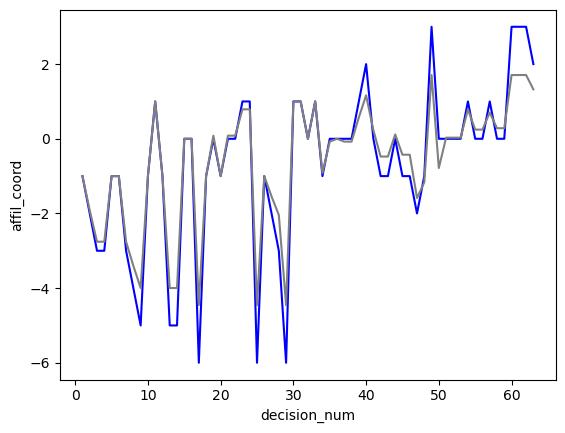

In [68]:
import seaborn as sns
# plot against time
sns.lineplot(data=behavior, x="decision_num", y="affil_coord", color='blue')
# sns.lineplot(data=behavior, x="decision_num", y="affil_coord_cf", color='grey')
sns.lineplot(data=behavior, x="decision_num", y="affil_coord_exponential-decay", color='grey')
# sns.lineplot(data=behavior, x="decision_num", y="power_coord", color='red')
plt.show()